# <center>Generate Map from Radar Images</center>
#### <center>Presented by: Maxwell Jung</center>

# Motivation - Unmanned Surface Vessel

- My 2024 UCSB Computer Engineering Capstone Project!
    - Presenting on Thrusday, June 6th, 8:30am ~ 12:30pm @ ESB 1001

<center><img src="img/usv.png" alt="usv" width="500"/></center>

# Image Source

- Radar Scan from UCSB Campus Lagoon

Satellite View (Google Maps) |  POV
:---------------------------:|:-------------------------:
<img src="img/lagoon-sat.png" alt="lagoon-sat" width="500"/>  |  <img src="img/lagoon.png" alt="lagoon" width="500"/>

# Radar Scans

<center><img src="img/radar-demo.gif" alt="radar-demo" width="500"/></center>

# Goal

- Stitch individual radar images into one giant map
    - Spoiler: unsuccessful due to heavy radial distortion

# Implemention

- Directly utilize this class's image stitching algorithm
    - Image Alignment and Stitching lecture on 05/15/2024 by Shawson Hsiao, Peicheng Wu, Shang-Hsun Yang

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [2]:
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder), key=lambda filename: int(filename.split('.')[0])):
        img = cv2.imread(os.path.join(folder,filename))
        if img is None: break
        
        img = crop(img)
        images.append(img)

    print(f'Loaded {len(images)} images')
    return images

# Load the images
images = load_images_from_folder('radar_image')

Loaded 389 images


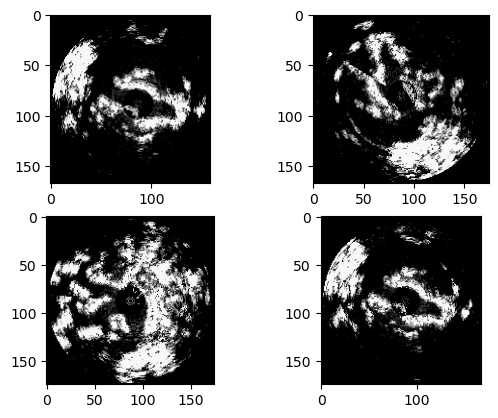

In [3]:
# show sample images from dataset
import random

sample_images = random.sample(images, 4)
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(sample_images[0])
axarr[0,1].imshow(sample_images[1])
axarr[1,0].imshow(sample_images[2])
axarr[1,1].imshow(sample_images[3])
plt.show()

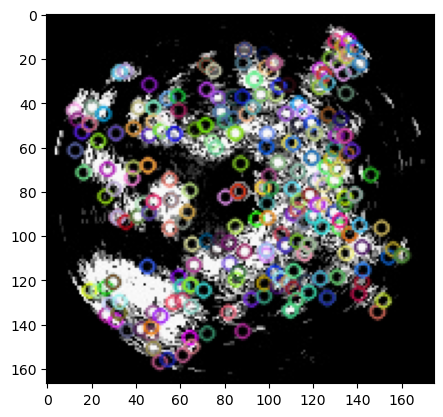

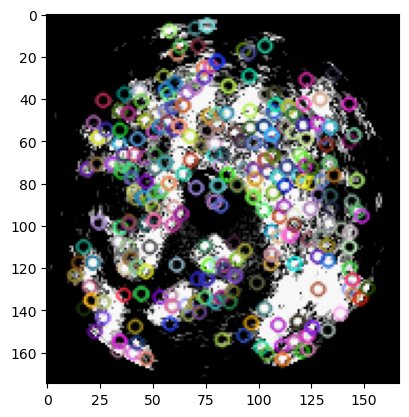

In [4]:
image1 = images[0]
image2 = images[50]

# Initialize the SIFT feature detector and extractor
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None)
image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None)

# Display the images with keypoints
plt.imshow(image1_keypoints)
plt.show()
plt.imshow(image2_keypoints)
plt.show()

In [5]:
def bf_match(descriptor1, descriptor2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck= True)
    matches = bf.match(descriptor1, descriptor2)
    matches = sorted(matches, key = lambda x: x.distance)
    return matches

def flann_match(descriptors1, descriptors2):
    flann = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50))
    matches = flann.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

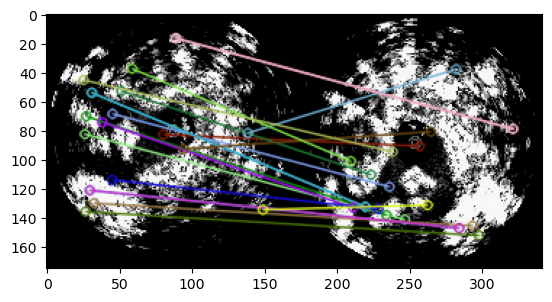

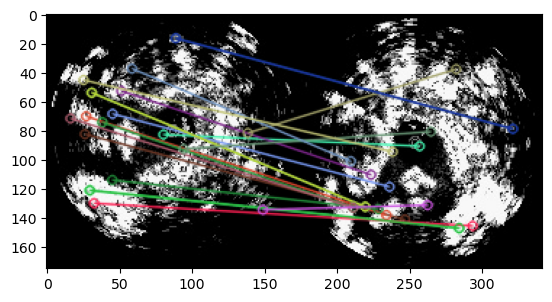

In [6]:
matches_bf = bf_match(descriptors1, descriptors2)
matches_flann = flann_match(descriptors1, descriptors2)

# Draw the top N matches
num_matches = 20
image_matches_bf = cv2.drawMatches(
    image1, 
    keypoints1, 
    image2, 
    keypoints2, 
    matches_bf[:num_matches], 
    None, 
    matchesThickness = 1, 
    flags = 2)
image_matches_flann = cv2.drawMatches(
    image1, 
    keypoints1, 
    image2, 
    keypoints2, 
    matches_flann[:num_matches], 
    None, 
    matchesThickness = 1, 
    flags = 2)

# Display the images with matches
plt.imshow(image_matches_bf)
plt.show()
plt.imshow(image_matches_flann)
plt.show()

In [7]:
# Extract the matched keypoints
src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches_bf]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches_bf]).reshape(-1, 1, 2)

# Estimate the homography matrix using RANSAC
homography, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

# Print the estimated homography matrix
print("Estimated Homography Matrix:")
print(homography)

Estimated Homography Matrix:
[[ 2.21195018e-01  1.05476983e+00 -1.92780606e+01]
 [-9.85737817e-01  3.16477243e-01  1.45236561e+02]
 [-6.40767747e-04  5.62084371e-04  1.00000000e+00]]


In [8]:
def get_homography(image1, image2, num_matches):
    # Initialize the SIFT feature detector and extractor
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for both images
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)
    
    # Select the top N matches
    matches = flann_match(descriptors1, descriptors2)
    if len(matches) < num_matches: raise Exception(f'Insufficient matches: {len(matches)}/{num_matches}')
    matches = matches[:num_matches]
    
    
    # Extract matching keypoints
    src_points = np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
    dst_points = np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)
    
    homography, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
    
    return homography

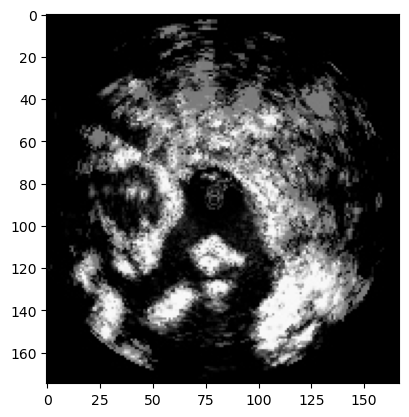

In [9]:
# Select the top N matches
num_matches = 50
matches = matches_bf[:num_matches]

# Extract matching keypoints
src_points = np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

# Estimate the homography matrix
homography, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

# Warp the first image using the homography
result = cv2.warpPerspective(image1, homography, (image2.shape[1], image2.shape[0]))

# Blending the warped image with the second image using alpha blending
alpha = 0.5  # blending factor
blended_image = cv2.addWeighted(result, alpha, image2, 1 - alpha, 0)

# Display the blended image
plt.imshow(blended_image)
plt.show()

In [10]:
def transformed_boundingbox(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    ptsA = np.float32([[0, 0], [0, h1], [w1, 0], [w1, h1]]).reshape(-1, 1, 2)
    ptsA_ = cv2.perspectiveTransform(ptsA, H)
    ptsB = np.float32([[0, 0], [0, h2], [w2, 0], [w2, h2]]).reshape(-1, 1, 2)
    
    # Use bult-in fuction boundingRect for computing the bounding box
    pts = np.concatenate((ptsA_, ptsB), axis=0)
    [x_min, y_min, w, h] = cv2.boundingRect(pts)
    return h, w

In [11]:
def translate_H(image, H):
    height = image.shape[0]
    width = image.shape[1]
    corners = np.array([[0, 0, 1],[width-1, 0, 1],[0, height-1, 1],[width-1, height-1, 1]], dtype = 'float32').T
    transformed_corners = H.dot(corners)
    transformed_corners /= transformed_corners[-1, :]
    minx = np.min(transformed_corners[0, :])
    miny = np.min(transformed_corners[1, :])
    maxx = np.max(transformed_corners[0, :])
    maxy = np.max(transformed_corners[1, :])

    smallest_x = int(np.floor(minx))
    smallest_y = int(np.floor(miny))
    
    # Move the left-bottom point to the first quadrant
    # Remain unchanged if the left-bottom point already at first quadrant, 
    translate_x = -smallest_x if smallest_x < 0 else 0
    translate_y = -smallest_y if smallest_y < 0 else 0
    
    distance = np.linalg.norm([translate_x, translate_y])
#     if distance > 200:
#         print(f'translation distance too high: {distance}')
#         return None
    
    translate_H = np.array([[1, 0, translate_x], [0, 1, translate_y], [0, 0, 1]], dtype = 'float32')
    return translate_H

In [12]:
# only the non-zero pixels are weighted to the average
def alpha_blend(img1, img2, alpha=0.5):
    assert(img1.shape == img2.shape)
    locs1 = np.where(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) != 0)
    blended1 = np.copy(img2)
    blended1[locs1[0], locs1[1]] = img1[locs1[0], locs1[1]]
    locs2 = np.where(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) != 0)
    blended2 = np.copy(img1)
    blended2[locs2[0], locs2[1]] = img2[locs2[0], locs2[1]]
    blended = cv2.addWeighted(blended1, alpha, blended2, 1-alpha, 0)
    return blended

In [13]:
def stitch_two_images(image1, image2, num_matches=50, alpha=0.5):
    # Estimate the homography matrix
    homography = get_homography(image1, image2, num_matches)
    
#     # Warp the first image using the homography
#     result = cv2.warpPerspective(image1, homography, (image2.shape[1], image2.shape[0]))

#     # Blending the warped image with the second image using alpha blending
#     blended_image = alpha_blend(result, image2, alpha)
    
    # Warp the first image using the homography
    height, width = transformed_boundingbox(image1, image2, homography)
    translation = translate_H(image1, homography)
    H_corr = translation.dot(homography)

    transformed_1to2 = cv2.warpPerspective(image1, H_corr, (width,height))
    translated_img2 = cv2.warpPerspective(image2, translation , (width,height))
    
    # Blending the warped image with the second image using alpha blending
    blended_image = alpha_blend(transformed_1to2, translated_img2)
    blended_image = crop(blended_image)
    
    if blended_image.size > 1.5 * image1.size:
        raise Exception(f"Dimension grew by {blended_image.size/image1.size:.2f} times")
    
    return blended_image

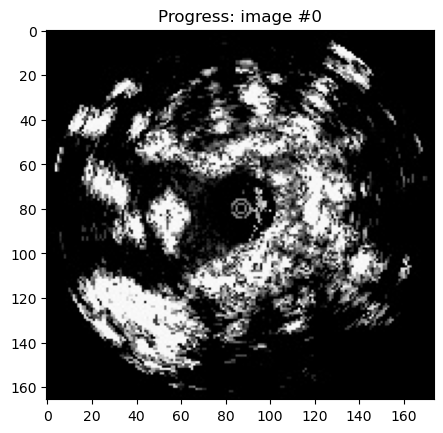

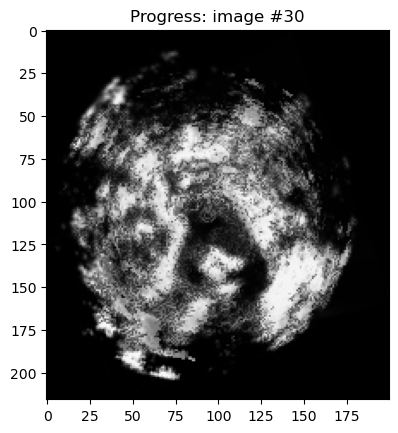

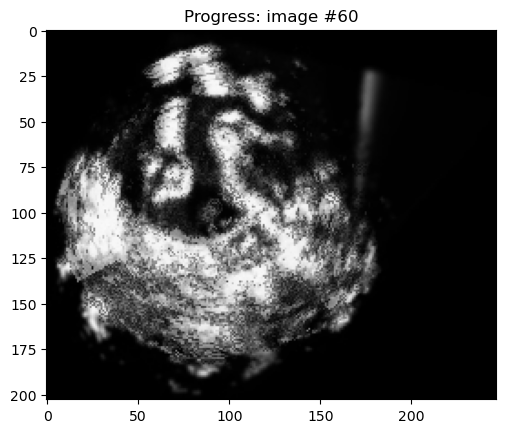

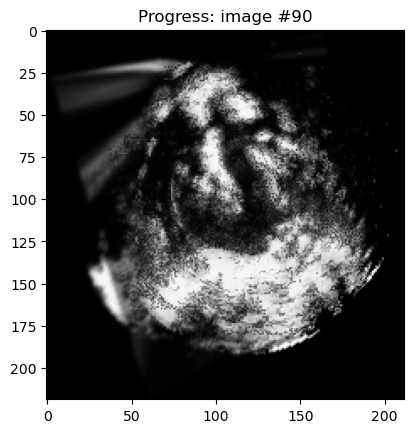

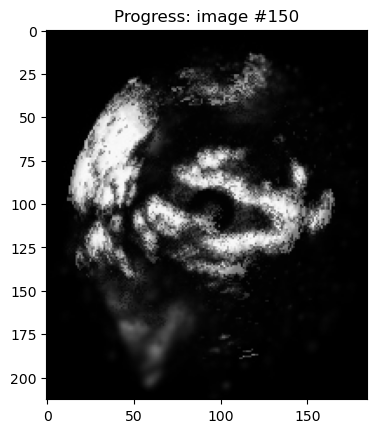

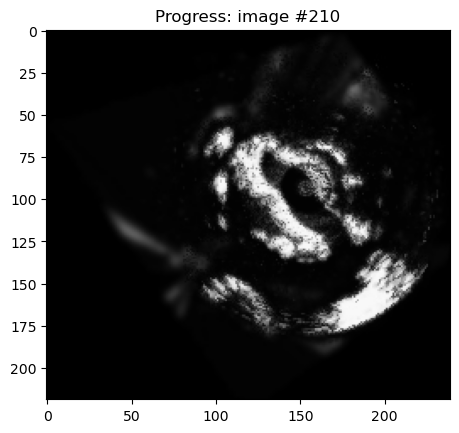

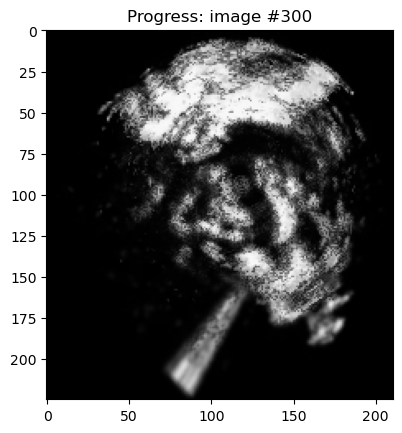

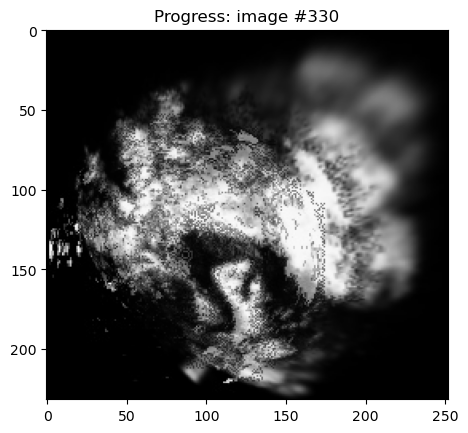

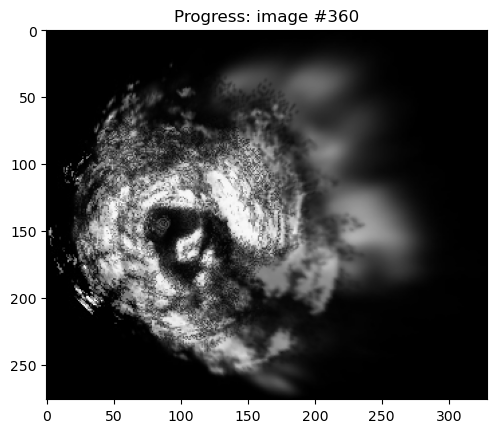

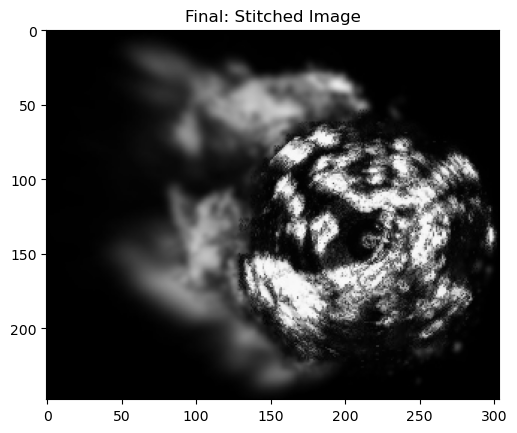

In [14]:
# skip_images = [17, 18, 20, 21, 25, 26, 27, 38, 39, 41, 43, 45, 46, 54, 62, 63, 64, 65, 76, 78, 79, 80, 81, 82, 99, 100, 103, 122, 224, 225, 226]
skip_images = []

image1 = images[0]
for i, image2 in enumerate(images):
    if i in skip_images: continue
    try:
        output = stitch_two_images(image1, image2, num_matches=50, alpha=0.5)
    except Exception as e:
#         print(f'Discarding image #{i}: {e}')
#         plt.title('image1')
#         plt.imshow(image1)
#         plt.show()
#         plt.title('image2')
#         plt.imshow(image2)
#         plt.show()
        continue
    image1 = output

    if (i%30 == 0):
        plt.title(f'Progress: image #{i}')
        plt.imshow(output)
        plt.show()

# Display stitched image
plt.title(f'Final: Stitched Image')
plt.imshow(image1)
plt.savefig('img/new-final-map.png', bbox_inches='tight')
plt.show()

# Comparison

Satellite View (Google Maps) |  Stitched Image
:---------------------------:|:-------------------------:
<img src="img/lagoon-sat-zoomed.png" alt="lagoon-sat-zoomed" width="500"/>  |  <img src="img/final-map.png" alt="final-map" width="500"/>

In [15]:
# OpenCV native Stitcher
stitcher = cv2.Stitcher.create()
samples = images[::40]
status, result = stitcher.stitch(samples)
  
if status == cv2.STITCHER_OK:
    print('Your Panorama is ready!!!') 
    plt.imshow(result)
    plt.show()
else:
    # checking if the stitching procedure is successful 
    # .stitch() function returns a true value if stitching is  
    # done successfully
    print("Stitching failed") 

Stitching failed


# Failure Analysis

- Radial/polar distortion

Boat Turning CounterClockwise |  Boat Turning Clockwise
:---------------------------:|:-------------------------:
<img src="img/distortion-1.jpg" alt="distortion-1" width="500"/> | <img src="img/distortion-2.jpg" alt="distortion-2" width="500"/>

# Failure Analysis

- Radial/polar distortion

 Minimal Distortion |  Heavy Distortion
:---------------------------:|:-------------------------:
<img src="img/distortion-3.jpg" alt="distortion-3" width="500"/> | <img src="img/distortion-4.jpg" alt="distortion-4" width="500"/>